<a target="_blank" href="https://colab.research.google.com/github/cyneuro/ML_camp/blob/main/camp_logreg_microbit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Logistic regression with micro:bit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## 1. Read and preprocess the data

- Read the recorded dataset.
- Compute velocity and position from acceleration.

In [2]:
# Convert milligravities to m/s2
MG_TO_MS2 = 0.00980665

def process_data(data):
    # Clean the columns
    orig_columns = ["time (seconds)", "x", "y", "z"]
    new_columns = ["t", "ax", "ay", "az"]
    data = data[orig_columns]
    data.columns = new_columns

    # Clean NaNs
    data = data.dropna()

    # Convert to m/s2
    for acc in ['ax', 'ay', 'az']:
        data[acc] = data[acc] * MG_TO_MS2

    # Replace outliers with the median
    for acc in ['ax', 'ay', 'az']:
        acc_raw = data[acc].copy()
        acc_raw[np.abs(acc_raw / np.median(acc_raw)) > 1.5] = np.median(acc_raw)
        data[acc] = acc_raw

    # Compute velocity
    data['vx'] = cumulative_trapezoid(data['ax'], data['t'], initial = 0)
    data['vy'] = cumulative_trapezoid(data['ay'], data['t'], initial = 0)
    data['vz'] = cumulative_trapezoid(data['az'], data['t'], initial = 0)

    # Compute position
    data['x'] = cumulative_trapezoid(data['vx'], data['t'], initial = 0)
    data['y'] = cumulative_trapezoid(data['vy'], data['t'], initial = 0)
    data['z'] = cumulative_trapezoid(data['vz'], data['t'], initial = 0)

    return data

In [3]:
data = pd.read_csv("shake_data.csv")
data = process_data(data)
data.head()

,t,ax,ay,az,vx,vy,vz,x,y,z
0,0.001,0.0,0.0,-10.032203,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.028,0.0,0.0,-10.032203,0.0,0.0,-0.270869,0.0,0.0,-0.003657
2,0.054,0.0,0.0,-10.032203,0.0,0.0,-0.531707,0.0,0.0,-0.014090
3,0.075,0.0,0.0,-10.032203,0.0,0.0,-0.742383,0.0,0.0,-0.027468
4,0.101,0.0,0.0,-10.032203,0.0,0.0,-1.003220,0.0,0.0,-0.050161


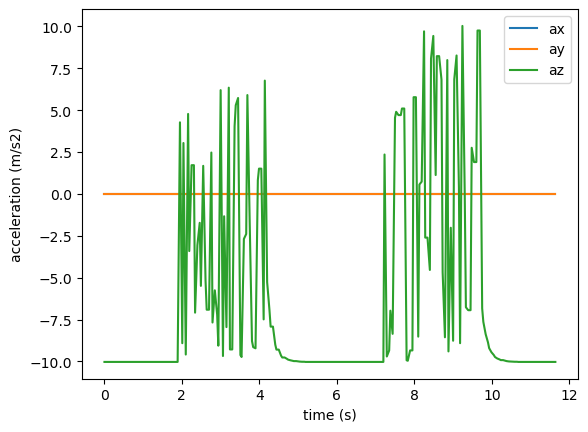

In [4]:
for acc in ['ax', 'ay', 'az']:
    plt.plot(data['t'], data[acc], label = acc)
plt.xlabel("time (s)")
plt.ylabel("acceleration (m/s2)")
plt.legend()

## 2. Split into train and test samples.
- Train: the first shake.
- Test: the second shake.

In [5]:
#TODO: adjust to your values

train_rest = (0.5, 1.8) # (seconds)
train_shake = (2.1, 4.0) # (seconds)

test_rest = (5.0, 7.0) # (seconds)
test_shake = (7.9, 10.0) # (seconds)

In [6]:
def construct_Xy(data, window_rest, window_shake):
    X = pd.concat((
        data.loc[(data['t'] >= window_rest[0]) & (data['t'] <= window_rest[1]), ['t', 'ax', 'ay', 'az']],
        data.loc[(data['t'] >= window_shake[0]) & (data['t'] <= window_shake[1]), ['t', 'ax', 'ay', 'az']],
    ))
    y = np.ones(len(X))
    y[(X['t'] >= window_rest[0]) & (X['t'] <= window_rest[1])] = 0

    return X, y

In [7]:
X_train, y_train = construct_Xy(data, train_rest, train_shake)
X_test, y_test = construct_Xy(data, test_rest, test_shake)

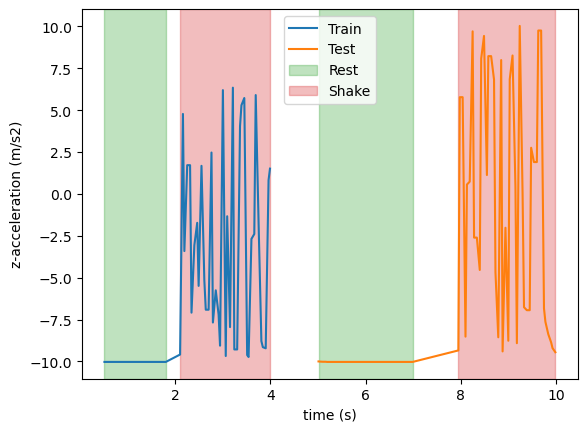

In [8]:
plt.plot(X_train['t'], X_train["az"], label = "Train")
plt.plot(X_test['t'], X_test["az"], label = "Test")

label_set = False
for X, y in [(X_train, y_train), (X_test, y_test)]:
    for y_value, y_label in enumerate(["Rest", "Shake"]):
        plt.axvspan(
            X['t'].to_numpy()[np.where(y == y_value)[0][0]], 
            X['t'].to_numpy()[np.where(y == y_value)[0][-1]],
            alpha = 0.3,
            color = "tab:green" if y_value == 0 else "tab:red",
            label = y_label if not label_set else None
            )
    label_set = True

plt.xlabel("time (s)")
plt.ylabel("z-acceleration (m/s2)")
plt.legend()

## 3. Train a logistic regression model

Compare 2 models.

**Model 1.**

$$
\hat{p} = \sigma(b_0 + b_t \times t + b_x \times a_x + b_y \times a_y + b_z \times a_z)
$$

**Model 2.**

$$
\hat{p} = \sigma(b_0 + b_x \times a_x + b_y \times a_y + b_z \times a_z)
$$

In [9]:
model1 = LogisticRegression()
model1.fit(X_train[["t", "ax", "ay", "az"]], y_train)

model2 = LogisticRegression()
model2.fit(X_train[["ax", "ay", "az"]], y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [10]:
print("ACCURACY")
print("--------")
print("Model\tTrain\tTest")
for model_id, (model, features) in enumerate((
    (model1, ["t", "ax", "ay", "az"]), 
    (model2, ["ax", "ay", "az"])
    )):
    train_acc = round(accuracy_score(y_train, model.predict(X_train[features])), 2)
    test_acc = round(accuracy_score(y_test, model.predict(X_test[features])), 2)
    print(f"M{model_id}\t{train_acc}\t{test_acc}")

ACCURACY
--------
Model	Train	Test
M0	0.98	0.51
M1	0.94	0.99


In [11]:
model1.predict(X_test[["t", "ax", "ay", "az"]])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
model2.predict(X_test[["ax", "ay", "az"]])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

### Question

Explain the observed difference between predictions of the two models.

**Hint: compare the decision lines.** 

In [13]:
print(f"Model1: intercept = {model1.intercept_}, coef = {model1.coef_}")
print(f"Model2: intercept = {model2.intercept_}, coef = {model2.coef_}")

Model1: intercept = [6.94079447], coef = [[2.0816512  0.         0.         1.23519815]]
Model2: intercept = [25.19626784], coef = [[0.         0.         2.67128043]]


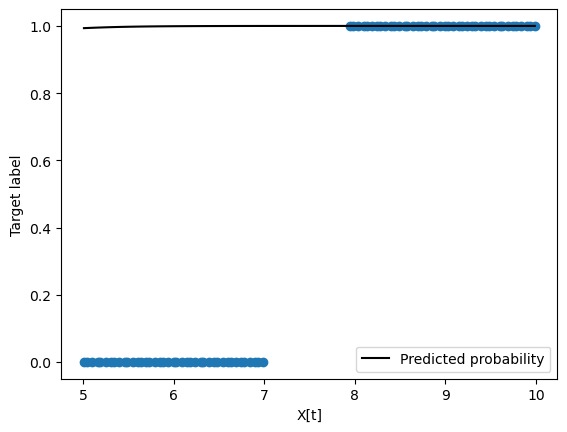

In [14]:
plt.scatter(X_test["t"], y_test)
plt.xlabel("X[t]")
plt.ylabel("Target label")

plt.plot(X_test["t"], model1.predict_proba(X_test[["t", "ax", "ay", "az"]])[:, 1], label = "Predicted probability", c = "black")
plt.legend()

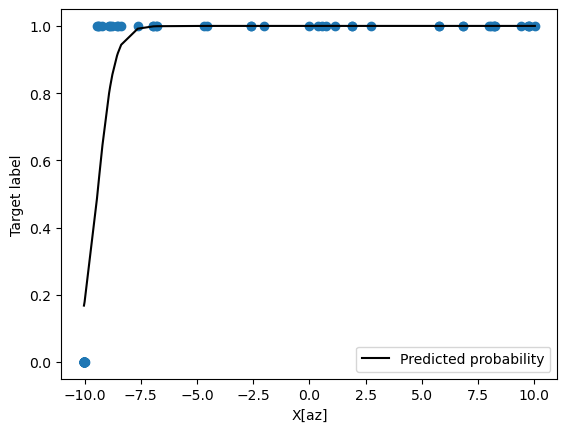

In [15]:
plt.scatter(X_test["az"], y_test)
plt.xlabel("X[az]")
plt.ylabel("Target label")

plt.plot(X_test.sort_values("az")["az"], model2.predict_proba(X_test.sort_values("az")[["ax", "ay", "az"]])[:, 1], label = "Predicted probability", c = "black")
plt.legend()